### Gambler's Ruin Problem in Quant Trading

A classic problem in hedge fund interviews - why?  For one, quantitative trading is the gambler's ruin problem.

Consider a *game of chance* (no optimal action to learn in uncertainty) where...
 
  $\text{Game Outcome} = \begin{cases} 
  p = \text{probability of winning} \\
  q = 1-p = \text{probability of losing}
  \end{cases}$

  $\text{Game Payout} = \begin{cases}
  +\$1 \text{ if win} \\
  -\$1 \text{ if loss}
  \end{cases}$

The structure of this problem is Markovian, only the current state matters in determining the next - not the entire path history.

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

---

#### Analytical Solution:

For our aspiring hedge fund analysts, the analytical solution is given by the following setup:
 
 Suppose a gambler starting with initial wealth $i$, target wealth $N$, and probability of winning $p$ in each game:
 
 The probability of ruin (hitting 0 before reaching target $N$) is:
 
 When $p = 0.5$ (fair game):
 $P(\text{ruin}) = 1 - \frac{i}{N}$
 
 When $p \neq 0.5$ (unfair game):
 $P(\text{ruin}) = \frac{1-(\frac{p}{q})^i}{1-(\frac{p}{q})^N}$ where $q=1-p$
 
 This shows that:
 1. Starting with more capital reduces ruin probability
 2. Having an edge (p > 0.5) dramatically improves survival
 3. Even with an edge, ruin is certain if playing indefinitely without a target

**Remark on 3:** The lack of an absorbing state for acquiring wealth (without a wealth target to stop playing) means at infinity every state will be visited infinitely often including the state where bankrupcy occurs and the chain is inevitably absorbed. 

#### Simulation:

Simulating outcomes of the game we can see ruin or riches (bankruptcy and target wealth reached in red and green respectively).

It is quite easy to compute the probability of reaching a wealth threshold in a simulation capacity by the Law of Large Numbers (LLN).

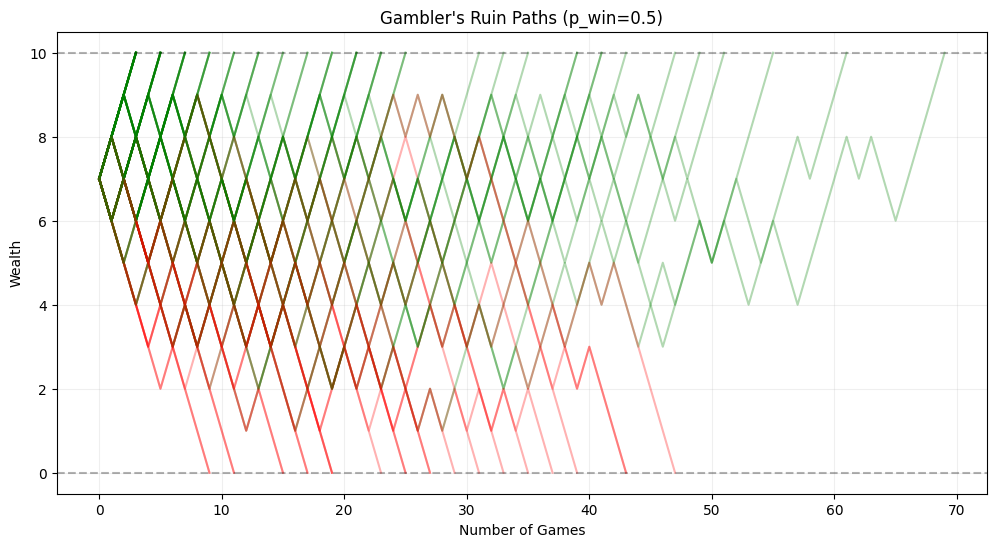

Proportion of paths reaching target wealth: 0.750


In [69]:
def simulate_path(p_win, initial_wealth=7, target_wealth=10, min_wealth=0):
    wealth = initial_wealth
    path = [wealth]
    
    while wealth > min_wealth and wealth < target_wealth:
        if random.random() < p_win:
            wealth += 1
        else:
            wealth -= 1
        path.append(wealth)
        
    return path, wealth >= target_wealth

# Run multiple simulations
n_sims = 100
p_win = 0.5
paths = []
outcomes = []

for _ in range(n_sims):
    path, success = simulate_path(p_win)
    paths.append(path)
    outcomes.append(success)

# Plotting
plt.figure(figsize=(12, 6))
for path, success in zip(paths, outcomes):
    if success:
        plt.plot(path, color='green', alpha=0.3)
    else:
        plt.plot(path, color='red', alpha=0.3)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axhline(y=10, color='black', linestyle='--', alpha=0.3)
plt.title(f"Gambler's Ruin Paths (p_win={p_win})")
plt.xlabel('Number of Games')
plt.ylabel('Wealth')
plt.grid(True, alpha=0.2)
plt.show()

# Calculate proportion of successful paths
success_rate = sum(outcomes) / len(outcomes)
print(f"Proportion of paths reaching target wealth: {success_rate:.3f}")


---

### A Trader's Expected Value

Let $\mathbb{E}$ define the expectation or *average* and a **trade** be any position that is opened and closed for P/L.

For any given trading system $\mathcal{T}$ we can say a $\text{trade} \in \mathcal{T}$ is a draw from the *true* distribution of $\mathcal{T}$ and the expected P/L as:

$\mathbb{E}[\mathcal{T}] = \mathbb{E}[\mathcal{T} | \text{win}]P(\text{win}) + \mathbb{E}[\mathcal{T} | \text{loss}]P(\text{loss})$

where it follows
- $\mathbb{E}[\mathcal{T}]$ is the expected value of a trade governed by $\mathcal{T}$

- $\mathbb{E}[\mathcal{T} | \text{win}]$ is the expected or average P/L of a winning trade

- $\mathbb{E}[\mathcal{T} | \text{loss}]$ is the expected or average P/L of a losing trade

- $P(\text{win})$ is the probability or (empirically, the proportion of) winning trades

- $P(\text{loss})$ is the probability or (empirically, the proportion of) losing trades 

Why does this matter?

---

### A Trading in a System (i.e. $\mathcal{T}$) is the Gambler's Ruin Problem

Suppose we fix the probabilities of winning and losing along with the wealth gained and lost.

This is the Gambler's Ruin Problem with an asymmetric payout structure.

#### Simulation:

We can leverage the law of large numbers to estimate these probabilities with ease!

In [74]:
rounds = 1000
p_win = .5
average_win = 1
average_loss = 1
p_loss = 1-p_win
initial_wealth = 10
stoppage = 100
hits = []

for i in range(rounds):
    wealth = initial_wealth
    while wealth > 0 and wealth < stoppage:
        if random.random() < p_win:
            wealth += average_win
        else:
            wealth -= average_loss
    hits.append(1 if wealth > 0 else 0)
    
print("Probability of ruin: ", (1 - np.mean(hits))*100, "%")
print("Probability of success: ", np.mean(hits)*100, "%")

Probability of ruin:  89.5 %
Probability of success:  10.5 %


#### Analytical Solution

For our aspiring hedge fund analysts, the analytical solution is given by
- $W = \text{target wealth}$ 
- $i = \text{initial wealth}$
- $\mathcal{G}$ be the event that goal $W$ is reached before losing all wealth
- $p, q = \text{probability of winner, loser}$
- $a, b = \text{average winner, loser}$

$r = \frac{p}{q} \frac{a}{b}$

$P(\mathcal{G}) = 1 - P(\text{Bankrupt}) = 1 - \frac{1 - r^{i / b}}{1 - r^{W / b}}$

In [73]:
# Inputs
p_win = 0.5
p_loss = 0.5
average_win = 1
average_loss = 1
initial_wealth = 10
stoppage = 100

# Compute r
r = (p_loss / p_win) * (average_win / average_loss)

# Convert wealth to units of average_loss
i = initial_wealth / average_loss
w = stoppage / average_loss

# Compute ruin probability
if abs(r - 1) < 1e-10:
    P = (w - i) / w
else:
    P = (1 - r ** i) / (1 - r ** w)

print(f"Probability of ruin: {P*100:.2f}%")
print(f"Probability of success: {(1 - P)*100:.2f}%")

Probability of ruin: 90.00%
Probability of success: 10.00%


---

### Empirical v. Theoretical Distribution

For any trading system $\mathcal{T}$ we can not **directly** observe any of the components of $\mathbb{E}[\mathcal{T}]$.

We aim to use data (e.g. trades, the empirical distribution) to inform these theoretical values.


**Remark:** Unfortunately for us, it is likely the true theoretical distribution will change over time making it difficult to discern if we are having a streak of bad luck or if the system $\mathcal{T}$ is destined to be unsuccessful and vice versa.  Nevertheless, we must examine these quantities "in the lab" so to speak so we can understand the potential impact in a time varying capacity and what we can do to mitigate the issue. 

#### Why we care about $\mathbb{E}[\mathcal{T}]$

$\mathbb{E}[\mathcal{T}] = \mathbb{E}[\mathcal{T} | \text{win}]P(\text{win}) + \mathbb{E}[\mathcal{T} | \text{loss}]P(\text{loss})$

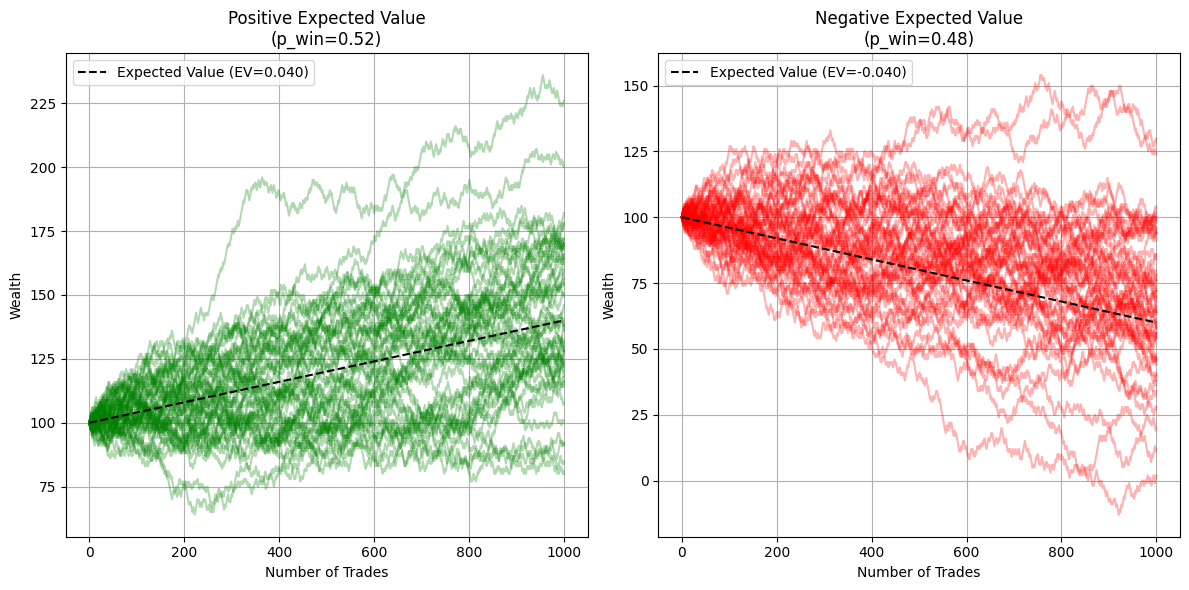

In [24]:
# Set up parameters for simulation
n_steps = 1000
n_paths = 50
initial_wealth = 100

# Parameters for positive EV scenario
p_win_pos = 0.52
avg_win_pos = 1
avg_loss_pos = 1
ev_pos = p_win_pos * avg_win_pos - (1-p_win_pos) * avg_loss_pos

# Parameters for negative EV scenario  
p_win_neg = 0.48
avg_win_neg = 1
avg_loss_neg = 1
ev_neg = p_win_neg * avg_win_neg - (1-p_win_neg) * avg_loss_neg

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Simulate positive EV paths
for _ in range(n_paths):
    wealth = initial_wealth
    wealth_path = [wealth]
    
    for _ in range(n_steps):
        if random.random() < p_win_pos:
            wealth += avg_win_pos
        else:
            wealth -= avg_loss_pos
        wealth_path.append(wealth)
        
    ax1.plot(wealth_path, alpha=0.3, color='green')

# Simulate negative EV paths    
for _ in range(n_paths):
    wealth = initial_wealth
    wealth_path = [wealth]
    
    for _ in range(n_steps):
        if random.random() < p_win_neg:
            wealth += avg_win_neg
        else:
            wealth -= avg_loss_neg
        wealth_path.append(wealth)
        
    ax2.plot(wealth_path, alpha=0.3, color='red')

# Add expected value lines
x = np.arange(n_steps + 1)
ax1.plot(x, initial_wealth + x * ev_pos, 'k--', label=f'Expected Value (EV={ev_pos:.3f})')
ax2.plot(x, initial_wealth + x * ev_neg, 'k--', label=f'Expected Value (EV={ev_neg:.3f})')

# Customize plots
ax1.set_title('Positive Expected Value\n(p_win=0.52)')
ax2.set_title('Negative Expected Value\n(p_win=0.48)') 
ax1.set_xlabel('Number of Trades')
ax2.set_xlabel('Number of Trades')
ax1.set_ylabel('Wealth')
ax2.set_ylabel('Wealth')
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)

plt.tight_layout()


#### Why we care about $P(\text{win}), P(\text{loss})$

$\mathbb{E}[\mathcal{T}] = \mathbb{E}[\mathcal{T} | \text{win}]P(\text{win}) + \mathbb{E}[\mathcal{T} | \text{loss}]P(\text{loss})$

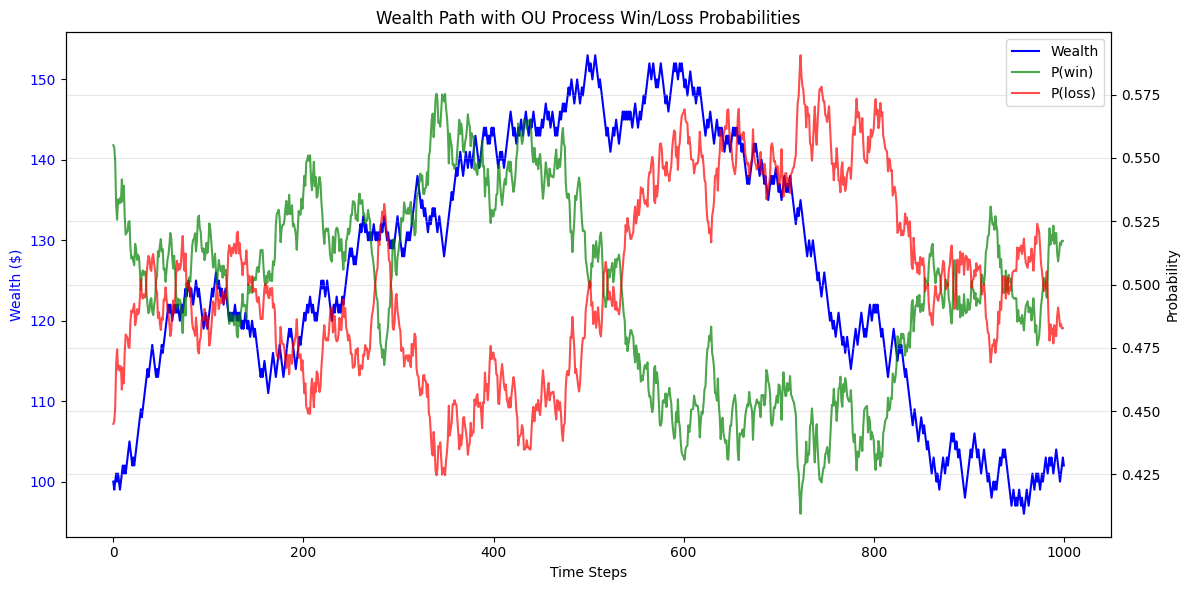

In [75]:
# Set up parameters
n_steps = 1000
initial_wealth = 100
p_win_mean = 0.5    # Mean reversion level
theta = 0.1         # Mean reversion speed
sigma = 0.05        # Volatility of OU process
dt = 0.01           # Time step
avg_win = 1
avg_loss = 1

# Initialize arrays
wealth_path = [initial_wealth]
p_win_path = []
p_loss_path = []
current_wealth = initial_wealth

# Initial win probability
p_win = 0.55  # Starting point

# Simulate trading with OU process for probabilities
for step in range(n_steps):
    # Update win probability using OU process
    dp_win = theta * (p_win_mean - p_win) * dt + sigma * np.sqrt(dt) * np.random.normal()
    p_win = p_win + dp_win
    
    # Ensure probability stays between 0 and 1
    p_win = np.clip(p_win, 0.01, 0.99)
    p_loss = 1 - p_win
    
    # Store probabilities
    p_win_path.append(p_win)
    p_loss_path.append(p_loss)
    
    # Simulate trade
    if random.random() < p_win:
        current_wealth += avg_win
    else:
        current_wealth -= avg_loss
    
    wealth_path.append(current_wealth)

# Create figure with twin y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot wealth path on first y-axis
ax1.plot(wealth_path, 'b-', label='Wealth')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Wealth ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create twin axis
ax2 = ax1.twinx()

# Plot probabilities on second y-axis
ax2.plot(p_win_path, 'g-', label='P(win)', alpha=0.7)
ax2.plot(p_loss_path, 'r-', label='P(loss)', alpha=0.7)
ax2.set_ylabel('Probability', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title("Wealth Path with OU Process Win/Loss Probabilities")
plt.grid(True, alpha=0.3)
plt.tight_layout()


#### Why we care about $\mathbb{E}[\mathcal{T} | \text{win}], \mathbb{E}[\mathcal{T} | \text{loss}]$

$\mathbb{E}[\mathcal{T}] = \mathbb{E}[\mathcal{T} | \text{win}]P(\text{win}) + \mathbb{E}[\mathcal{T} | \text{loss}]P(\text{loss})$

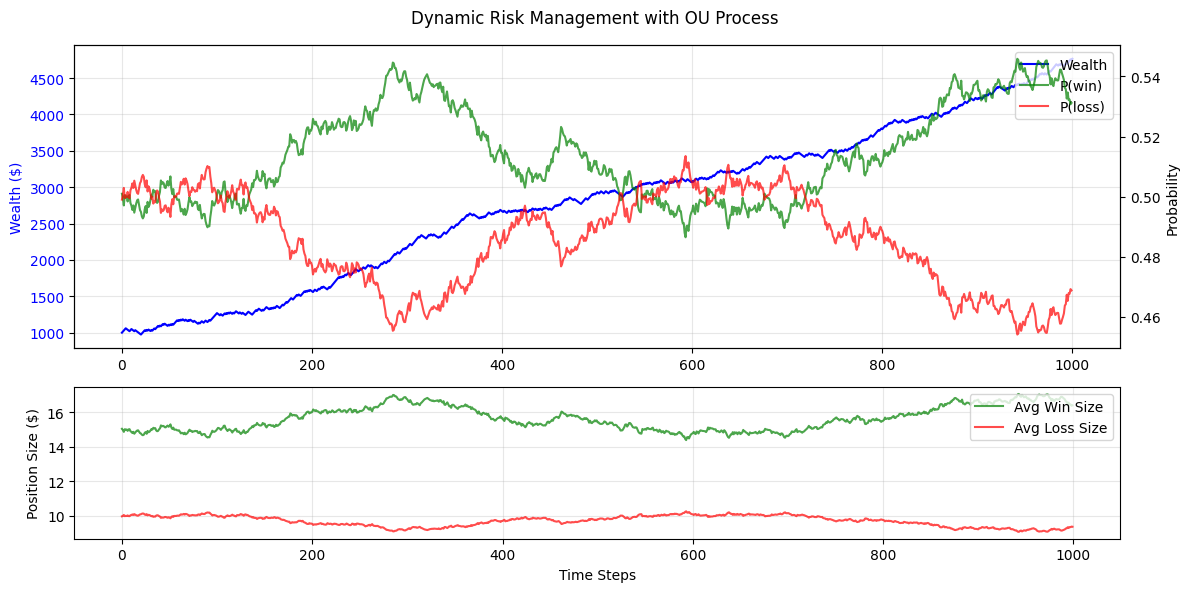

In [36]:
# Reset simulation parameters
n_steps = 1000
current_wealth = 1000
wealth_path = [current_wealth]
p_win_path = []
p_loss_path = []
avg_win_path = []
avg_loss_path = []

# OU Process parameters
theta = 0.1  # Mean reversion strength
mu = 0.5    # Mean level
sigma = 0.05 # Volatility
p = 0.5     # Initial probability

for t in range(n_steps):
    # Update probability using OU process
    dp = theta * (mu - p) * 1/n_steps + sigma * np.sqrt(1/n_steps) * np.random.normal()
    p = p + dp
    p = np.clip(p, 0.01, 0.99)  # Ensure p stays between 0.01 and 0.99
    
    p_win = p
    p_loss = 1 - p_win
    
    # Adjust position sizing based on probability
    # Take larger positions when probability is high
    # Take smaller positions when probability is low
    confidence_multiplier = 1 + (p_win - 0.5) * 2  # Scales from 0 to 2
    
    # Dynamic risk management - both win and loss sizes vary with probability
    base_win = 15
    base_loss = 10
    
    # Win size increases with win probability
    avg_win = base_win * (1 + (p_win - 0.5) * 3)  # Scales from 7.5 to 22.5
    
    # Loss size decreases with win probability
    avg_loss = base_loss * (1 - (p_win - 0.5) * 2)  # Scales from 5 to 15
    
    # Store values
    p_win_path.append(p_win)
    p_loss_path.append(p_loss)
    avg_win_path.append(avg_win)
    avg_loss_path.append(avg_loss)
    
    # Simulate trade
    if random.random() < p_win:
        current_wealth += avg_win
    else:
        current_wealth -= avg_loss
    
    wealth_path.append(current_wealth)

# Create figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), height_ratios=[2, 1])

# Plot wealth path on first subplot
ax1.plot(wealth_path, 'b-', label='Wealth')
ax1.set_ylabel('Wealth ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

# Create twin axis for probabilities
ax1_twin = ax1.twinx()
ax1_twin.plot(p_win_path, 'g-', label='P(win)', alpha=0.7)
ax1_twin.plot(p_loss_path, 'r-', label='P(loss)', alpha=0.7)
ax1_twin.set_ylabel('Probability', color='k')
ax1_twin.tick_params(axis='y', labelcolor='k')

# Plot position sizes on second subplot
ax2.plot(avg_win_path, 'g-', label='Avg Win Size', alpha=0.7)
ax2.plot(avg_loss_path, 'r-', label='Avg Loss Size', alpha=0.7)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Position Size ($)')
ax2.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax2.legend(loc='upper right')

plt.suptitle("Dynamic Risk Management with OU Process")
plt.tight_layout()


---

#### Example: Applying Gambler's Ruin Solution to a Trading System $\mathcal{T}$

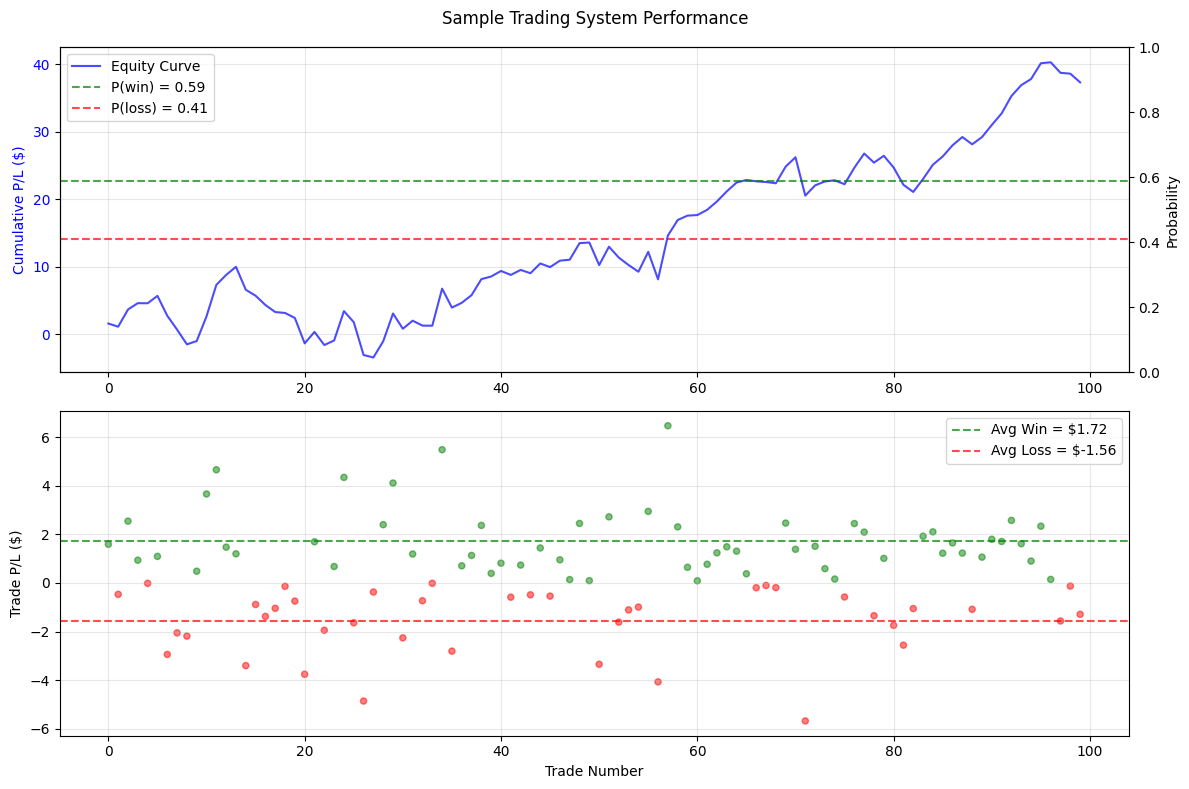

In [120]:
# Generate sample trade data
n_trades = 100

# Generate random trades with slight positive edge
trades = np.random.normal(0.2, 2, n_trades)  # Mean 0.2, std 2
equity_curve = np.cumsum(trades)

# Calculate win/loss metrics
winners = trades[trades > 0]
losers = trades[trades < 0]

p_win = len(winners) / n_trades
p_loss = len(losers) / n_trades
avg_win = np.mean(winners)
avg_loss = np.mean(losers)

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot equity curve
ax1.plot(equity_curve, 'b-', label='Equity Curve', alpha=0.7)
ax1.set_ylabel('Cumulative P/L ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

# Add win/loss probability lines
ax1_twin = ax1.twinx()
ax1_twin.axhline(y=p_win, color='g', linestyle='--', label=f'P(win) = {p_win:.2f}', alpha=0.7)
ax1_twin.axhline(y=p_loss, color='r', linestyle='--', label=f'P(loss) = {p_loss:.2f}', alpha=0.7)
ax1_twin.set_ylabel('Probability', color='k')
ax1_twin.tick_params(axis='y', labelcolor='k')

# Plot trade sizes
ax2.axhline(y=avg_win, color='g', linestyle='--', label=f'Avg Win = ${avg_win:.2f}', alpha=0.7)
ax2.axhline(y=avg_loss, color='r', linestyle='--', label=f'Avg Loss = ${avg_loss:.2f}', alpha=0.7)
ax2.scatter(range(n_trades), trades, c=['g' if t > 0 else 'r' for t in trades], alpha=0.5, s=20)
ax2.set_xlabel('Trade Number')
ax2.set_ylabel('Trade P/L ($)')
ax2.grid(True, alpha=0.3)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax2.legend(loc='upper right')

plt.suptitle("Sample Trading System Performance")
plt.tight_layout()


#### Gambler's Ruin Simulation for Trading System Wealth

In [114]:
rounds = 1000
p_win = .53
average_win = 1.57
average_loss = 1.49
p_loss = 1-p_win
initial_wealth = 5
stoppage = 10
hits = []

for i in range(rounds):
    wealth = initial_wealth
    while wealth > 0 and wealth < stoppage:
        if random.random() < p_win:
            wealth += average_win
        else:
            wealth -= average_loss
    hits.append(1 if wealth > 0 else 0)
    
print("Probability of ruin: ", (1 - np.mean(hits))*100, "%")
print("Probability of success: ", np.mean(hits)*100, "%")

Probability of ruin:  36.3 %
Probability of success:  63.7 %


#### Measurement Concerns and Closing Thoughts

It is *not difficult* to measure these quantities, anyone can trade and take the mean or standard deviation.  

It is, however, **difficult** to measure these quantities accurately as a function of time.

Likely, we will be under/over estimating the probabilities of success/failure and winning/losing trade P/L.

All of our models are certainly wrong - but that does not preclude us from making money even with violated assumptions.